Nesse projeto uso LSTM para descobrir qual é o preço de fechamento do bitcoin. Uso 5 features relativas ao candle de negociação diária e prevejo o preço de fechamento do dia seguinte



In [ ]:
# !pip install keras-tuner
# !pip install tensorflow
# !pip install numpy
# !pip install pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 11.4 MB/s eta 0:00:00


In [ ]:
#Importar as bibliotecas necessárias
import os
import pandas as pd
import numpy as np
import math
import datetime
import time

# Importar sklearn para avaliar o modelo
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing  import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
# from scikeras.wrappers import KerasRegressor
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor


from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
# Importar tensorflow para construir o modelo
import tensorflow as tf
import keras
from keras import optimizers
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, History, EarlyStopping
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam

# Importar bibliotecas para plotar gráficos

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots



## Variaveis Globais

In [ ]:
TIME_STEP = 60           #número de dias usados para prever o futuro
JUMP_STEP = 1
NUM_FEATURES = 5
NUM_PREDICT_FUTURE = 30      #número do dia a serem preditos no futuro (prever o próximo dia? Prever o 7º dia?)
PATH = './drive/MyDrive/TCC/single_lstm_regression12/'
THRESHOLD = 5


## Definição das Seeds


In [ ]:
import tensorflow as tf
import numpy as np

# Defina a semente do TensorFlow
tf.random.set_seed(0)

# Defina a semente do NumPy
np.random.seed(0)


## Importar a Base de Dados

In [ ]:
ticker = 'BTC-USD'
#1410825600
initial_period = int(time.mktime(datetime.datetime(2014, 9, 16, 0, 0).timetuple()))

#1675814400
final_period = int(time.mktime(datetime.datetime(2023, 10, 31, 0, 0).timetuple()))
# 3067 valores. 2300 é 75%
interval = '1d' # 1d, 1wk, 1m

query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1={initial_period}&period2={final_period}&interval={interval}&events=history&includeAdjustedClose=true'

data = pd.read_csv(query_string)
df = pd.DataFrame(data, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')


Função para escolher os dados utilizados de forma sequencial. A cada t valores


In [ ]:
# def selecionaValores(df, jump_step):
#   return df[0::jump_step]

# df = selecionaValores(df, JUMP_STEP)

Preparação dos Dados:

In [ ]:
# Retira a Data e coloca como Index
df.index = df.pop('Date')

data.dropna(inplace=True)
data.reset_index(inplace = True)


In [ ]:
# Definir os dataframes dos objetivos a serem alcançados pelo modelo. O Y. Baseados no TimeStep e numero do dia a ser predito

ignoreDays = TIME_STEP + NUM_PREDICT_FUTURE - 1
index = np.array(df.index)[ignoreDays:]

# Dataframe com o valor de fechamento
target_df_Close = pd.DataFrame(df['Close'], index, ['Close']).rename(columns={'Close':'YClose'})

# Dataframe com a variação nominal entre os dias
array_change = np.array(target_df_Close.YClose) - np.array(df['Close'])[TIME_STEP-1 : -NUM_PREDICT_FUTURE]
target_df_Change = pd.DataFrame(array_change, index, columns=['Close']).rename(columns={'Close':'YChange'})

# Dataframe com a variação percentual entre os dias
array_variation = np.array(target_df_Change.YChange) / np.array(df['Close'])[TIME_STEP-1 : -NUM_PREDICT_FUTURE]
target_df_Variation = pd.DataFrame(array_variation*100, index, ['Close']).rename(columns={'Close':'YVariation'})


# Dataframe com a Classe baseado na variação percentual entre os dias
def defineClass(variation, THRESHOLD):
  if variation > THRESHOLD:
    return 2
  elif variation < -THRESHOLD:
    return 0
  else:
    return 1
# Apply the defineClass function to each data point in the array_variation
classifications = [defineClass(variation*100, 3) for variation in array_variation]
target_df_Class3 = pd.DataFrame(classifications, index, ['Close']).rename(columns={'Close':'YClass'})

# Apply the defineClass function to each data point in the array_variation
classifications = [defineClass(variation*100, 5) for variation in array_variation]
target_df_Class5 = pd.DataFrame(classifications, index, ['Close']).rename(columns={'Close':'YClass'})

# Apply the defineClass function to each data point in the array_variation
classifications = [defineClass(variation*100, 7) for variation in array_variation]
target_df_Class7 = pd.DataFrame(classifications, index, ['Close']).rename(columns={'Close':'YClass'})

In [ ]:
# Imprimir informações sobre o tamanho das séries de dados
print(f'df.Close.size: {df.Close.size}')
print(f'target_df_Close.size: {target_df_Close.size}')
print(f'target_df_Change.size: {target_df_Change.size}')
print(f'target_df_Variation.size: {target_df_Variation.size}')
print()

df.Close.size: 3332
target_df_Close.size: 3243
target_df_Change.size: 3243
target_df_Variation.size: 3243



In [ ]:
#plt.plot(df.index, df['Close'])

## Divisão em Treino, Validação e Teste

In [ ]:
# Divisão entre 70% treino, 10% validação e 20% teste
size = len(target_df_Close)
train_size = int(size * 0.7)
validation_size = int(size * 0.1)
test_size = size - train_size - validation_size

x_train_data = df[: train_size + TIME_STEP - 1]
x_val_data = df[ train_size : (train_size + validation_size + TIME_STEP - 1)]
x_test_data = df[train_size + validation_size : -NUM_PREDICT_FUTURE]

y_train_data = target_df_Close[: train_size]
y_val_data = target_df_Close[train_size : (train_size + validation_size)]
y_test_data = target_df_Close[(train_size + validation_size) :]

#Serão usados nas etapas finais do projeto
y_train_class3 = target_df_Class3[: train_size]
y_val_class3 = target_df_Class3[train_size : (train_size + validation_size)]
y_test_class3 = target_df_Class3[(train_size + validation_size) :]

y_train_class5 = target_df_Class5[: train_size]
y_val_class5 = target_df_Class5[train_size : (train_size + validation_size)]
y_test_class5 = target_df_Class5[(train_size + validation_size) :]

y_train_class7 = target_df_Class7[: train_size]
y_val_class7 = target_df_Class7[train_size : (train_size + validation_size)]
y_test_class7 = target_df_Class7[(train_size + validation_size) :]

y_train_variation = target_df_Variation[: train_size]
y_val_variation = target_df_Variation[train_size : (train_size + validation_size)]
y_test_variation = target_df_Variation[(train_size + validation_size) :]




In [ ]:
# Imprimir informações sobre os tamanhos dos dados
print('Tamanhos dos dados:')
print(f'size: {size}')
print(f'train_size: {train_size}')
print(f'validation_size: {validation_size}')
print(f'test_size: {test_size}')
print()

Tamanhos dos dados:
size: 3243
train_size: 2270
validation_size: 324
test_size: 649



In [ ]:
# Imprimir os tamanhos dos dados em linhas separadas
print('x_train_data.shape:', x_train_data.shape)
print('x_val_data.shape:', x_val_data.shape)
print('x_test_data.shape:', x_test_data.shape)
print('y_train_data.shape:', y_train_data.shape)
print('y_val_data.shape:', y_val_data.shape)
print('y_test_data.shape:', y_test_data.shape)
print()

x_train_data.shape: (2329, 5)
x_val_data.shape: (383, 5)
x_test_data.shape: (708, 5)
y_train_data.shape: (2270, 1)
y_val_data.shape: (324, 1)
y_test_data.shape: (649, 1)



In [ ]:
#Transforma os dados para suavizar as variações em escala absoluta
# Transforma input data
scaler_train_input = MinMaxScaler(feature_range=(0, 1))
scaled_train_input = scaler_train_input.fit_transform(x_train_data)

scaled_val_input = scaler_train_input.transform(x_val_data)
scaled_test_input = scaler_train_input.transform(x_test_data)

# Transforma output data para o log do resultado
# scaled_train_output = np.array(y_train_data)
# scaled_val_output = np.array(y_val_data)
# scaled_test_output = np.array(y_test_data)
scaled_train_output = np.log10(np.array(y_train_data))
scaled_val_output = np.log10(np.array(y_val_data))
scaled_test_output = np.log10(np.array(y_test_data))

In [ ]:
def createDataset(x, y, time_step=1):
  input = []
  output = []
  for i in range(len(y)):
    row = np.array([e for e in x[i : i + time_step]])
    input.append(row)
    output.append(y[i])
  return np.array(input), np.array(output)

x_train, y_train = createDataset(scaled_train_input, scaled_train_output, TIME_STEP)
x_val, y_val = createDataset(scaled_val_input, scaled_val_output, TIME_STEP)
x_test, y_test = createDataset(scaled_test_input, scaled_test_output, TIME_STEP)


In [ ]:
# Imprimir informações sobre as formas dos DataFrames e arrays
print('Formas dos DataFrames e arrays:')
print(f'df.shape: {df.shape}')
print(f'x_train.shape: {x_train.shape}, y_train.shape: {y_train.shape}')
print(f'x_val.shape: {x_val.shape}, y_val.shape: {y_val.shape}')
print(f'x_test.shape: {x_test.shape}, y_test.shape: {y_test.shape}')
print()

Formas dos DataFrames e arrays:
df.shape: (3332, 5)
x_train.shape: (2270, 60, 5), y_train.shape: (2270, 1)
x_val.shape: (324, 60, 5), y_val.shape: (324, 1)
x_test.shape: (649, 60, 5), y_test.shape: (649, 1)



## Construção do Modelo LSTM

### Random Search com LSTM



In [ ]:
import keras_tuner as kt
import keras.backend as K

def build_singleLayer_lstm_model(hp):
  #Variables to change with RandomSearch
  units = hp.Int('num_lstm_units', min_value=16, max_value=128, step=16)
  dropout = hp.Float('dropout_rate', min_value=0, max_value=0.4)
  learningRate = hp.Float('learning_rate', min_value=0.001, max_value=0.1, sampling='log')
  activation = hp.Choice('activation', ['tanh', 'relu'])

  model = keras.Sequential()
  model.add(LSTM(
      units = units,
      return_sequences=False,
      input_shape = (x_train.shape[1], x_train.shape[2]),
      activation=activation
      ))
  model.add(Dropout(dropout))
  model.add(Dense(1))
  optimizer = Adam(learning_rate=learningRate)
  model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mean_squared_error'])
  return model

earlystopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

tuner = kt.RandomSearch(
    build_singleLayer_lstm_model,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=1,
    directory=PATH,
    overwrite=True,
    project_name='lstm_tuning')

tuner.search_space_summary()

tuner.search(x_train, y_train, epochs=25, validation_data=(x_val, y_val), callbacks=[earlystopping], batch_size=32, verbose=1)
tuner.results_summary()

#Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0];
best_model.save(PATH + 'best_model_tunner.hdf5');
best_model.build(x_train.shape);
best_model.summary();
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0];


Trial 100 Complete [00h 02m 22s]
val_loss: 0.025942547246813774

Best val_loss So Far: 0.006171107292175293
Total elapsed time: 02h 54m 32s
Results summary
Results in ./drive/MyDrive/TCC/single_lstm_regression12/lstm_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 042 summary
Hyperparameters:
num_lstm_units: 32
dropout_rate: 0.09553764814408688
learning_rate: 0.04160097851397762
activation: tanh
Score: 0.006171107292175293

Trial 041 summary
Hyperparameters:
num_lstm_units: 64
dropout_rate: 0.07910834627848998
learning_rate: 0.04729436202637011
activation: tanh
Score: 0.006239968352019787

Trial 080 summary
Hyperparameters:
num_lstm_units: 32
dropout_rate: 0.20942065596504864
learning_rate: 0.07215054037466746
activation: tanh
Score: 0.006289452780038118

Trial 017 summary
Hyperparameters:
num_lstm_units: 16
dropout_rate: 0.14177909762951627
learning_rate: 0.062147277551298466
activation: tanh
Score: 0.006310649681836367

Trial 088 summary
Hyperparamete

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4897 (19.13 KB)
Trainable params: 4897 (19.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Mostra Treina o melhor modelo com EarlyStop

In [ ]:
best_model = load_model(PATH + 'best_model_tunner.hdf5')
best_model.build(x_train.shape);
best_model.summary();

earlystopping = EarlyStopping(monitor='val_loss', patience=100, restore_best_weights=True)

#Define um checkpoint para a melhor época
checkpoint_path = PATH + 'best_model_earlyStop.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint, earlystopping]
#Train the best model
history = best_model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_val, y_val), verbose=1,
                              callbacks=callbacks)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4897 (19.13 KB)
Trainable params: 4897 (19.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500


71/71 [==============================] - ETA: 0s - loss: 0.2150 - mean_squared_error: 0.2150
Epoch 1: val_loss improved from inf to 0.02258, saving model to ./drive/MyDrive/TCC/single_lstm_regression12/best_model_earlyStop.hdf5
71/71 [==============================] - 4s 41ms/step - loss: 0.2150 - mean_squared_error: 0.2150 - val_loss: 0.0226 - val_mean_squared_error: 0.0226
Epoch 2/500
70/71 [============================>.] - ETA: 0s - loss: 0.0478 - mean_squared_error: 0.0478
Epoch 2: val_loss did not improve from 0.02258
71/71 [==============================] - 2s 27ms/step - loss: 0.0477 - mean_squared_error: 0.0477 - val_loss: 0.0733 - val_mean_squared_error: 0.0733
Epoch 3/500
71/71 [==============================] - ETA: 0s - loss: 0.0434 - mean_squared_error: 0.0434
Epoch 3: val_loss did not improve from 0.02258
71/71 [==============================] - 2s 31ms/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0539 - val_mean_squared_error: 0.0539
Epoch 4/500
71/71 

## Resultados


Gráfico de Perda por Época


In [ ]:
checkpoint_path = PATH + 'best_model_earlyStop.hdf5'
loaded_model = load_model(checkpoint_path)
output_file = open(PATH + "saida.txt", "w")

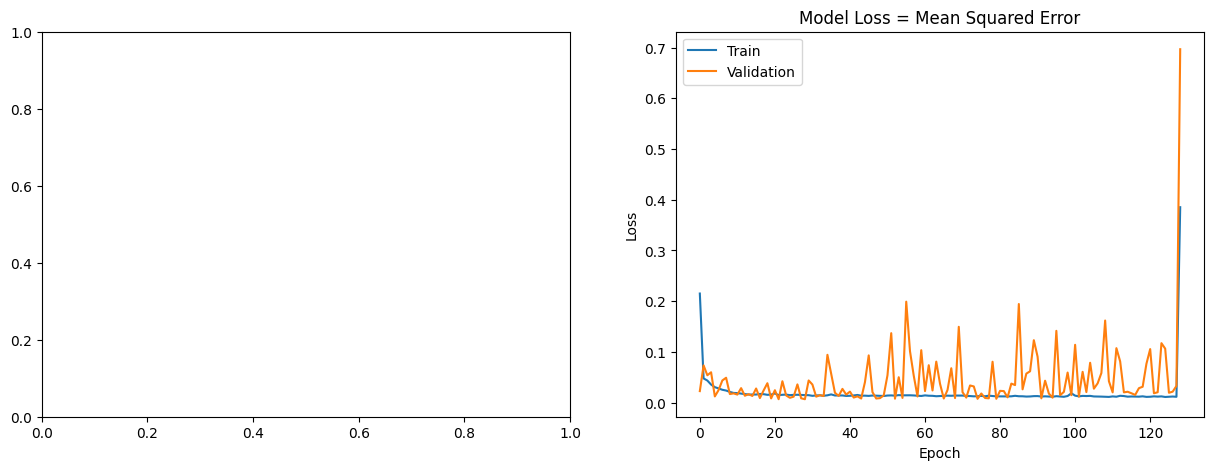

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ax1.plot(history.history['r_square'])
# ax1.plot(history.history['val_r_square'])
# ax1.set_title('Model r_square')
# ax1.set_ylabel('r_square')
# ax1.set_xlabel('Epoch')
# ax1.legend(['Train', 'Validation'], loc='upper left')


ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss = Mean Squared Error')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
plt.show()



Métricas de Desempenho


In [ ]:
y_train_predict_log = loaded_model.predict(x_train)

y_val_predict_log = loaded_model.predict(x_val)

y_test_predict_log = loaded_model.predict(x_test)

def printResults(expected, result):
  mse = mean_squared_error(expected, result)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(expected, result)
  r2 = r2_score(expected, result)
  mape = np.mean(np.abs((expected - result) / expected)) * 100
  print(f"MAE: {mae}")
  print(f"MSE: {mse}")
  print(f"RMSE: {rmse}")
  print(f"MAPE: {mape}%")
  print(f"R²: {r2}")

print('----- Métricas de Regressão -----')
print('------------- Train -------------')
printResults(y_train, y_train_predict_log)
print('---------- Validation -----------')
printResults(y_val, y_val_predict_log)
print('-------------- Test -------------')
printResults(y_test, y_test_predict_log)
print()



21/21 [==============================] - 0s 11ms/step
----- Métricas de Regressão -----
------------- Train -------------
MAE: 0.07855440836347717
MSE: 0.010918802623049013
RMSE: 0.10449307452194626
MAPE: 2.2819454670713872%
R²: 0.9745650503663033
---------- Validation -----------
MAE: 0.06940895026384718
MSE: 0.0065885538065536915
RMSE: 0.08116990702565632
MAPE: 1.4845793222639585%
R²: 0.14027833163240855
-------------- Test -------------
MAE: 0.064489160311398
MSE: 0.0069520264843303935
RMSE: 0.08337881316216005
MAPE: 1.467107271750343%
R²: 0.4905061189765809



## Transformar Regressão e Classes


In [ ]:
print("Target Class Threshold: 3")
class_counts = target_df_Class3['YClass'].value_counts().sort_index()
print(class_counts)
print()

print("Target Class Threshold: 5")
class_counts = target_df_Class5['YClass'].value_counts().sort_index()
print(class_counts)
print()

print("Target Class Threshold: 7")
class_counts = target_df_Class7['YClass'].value_counts().sort_index()
print(class_counts)
print()
print()

Target Class Threshold: 3
0    1183
1     431
2    1629
Name: YClass, dtype: int64

Target Class Threshold: 5
0    1026
1     721
2    1496
Name: YClass, dtype: int64

Target Class Threshold: 7
0     912
1     990
2    1341
Name: YClass, dtype: int64




In [ ]:
# y_test_predict = valor predito
# y_test = preço real
# y_test_class = a classe da variação percentual real
# y_test_variation = a variação percentual real
# Para prever o percentual predito, é necessário encontrar o valor real anterior
# Para isso, deve-se usar o valor real e a variação real. Variação = (V_final - V_inicial)/V_inicial

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
def printClassificationResults(y_test_class):
  y_test_predict = 10 ** y_test_predict_log
  y_test_real = 10 ** y_test
  y_test_class = np.array(y_test_class)

  def defineClass(variation):
    if variation > THRESHOLD:
      return 2
    elif variation < -THRESHOLD:
      return 0
    else:
      return 1
  def find_initial_price(preco_final, variacao_percentual):
    return preco_final / (1 + (variacao_percentual / 100))

  y_test_initial = [find_initial_price(y_test_real[i], np.array(y_test_variation)[i]) for i in range(len(y_test_real))]

  y_test_variation_predict = ((y_test_predict - y_test_initial) / y_test_initial) * 100

  y_test_class_predict = [defineClass(variation) for variation in y_test_variation_predict]


  # Transforme as classes reais e previstas em rótulos binários
  lb = LabelBinarizer()
  y_test_class_bin = lb.fit_transform(y_test_class)
  y_test_class_predict_bin = lb.transform(y_test_class_predict)

  accuracy = accuracy_score(y_test_class, y_test_class_predict)
  # Precisão, Recall e F1-Score (para cada classe)
  precision = precision_score(y_test_class, y_test_class_predict, average=None)
  recall = recall_score(y_test_class, y_test_class_predict, average=None)
  f1 = f1_score(y_test_class, y_test_class_predict, average=None)
  roc_auc = roc_auc_score(y_test_class_bin, y_test_class_predict_bin, average=None)

  average_precision = precision_score(y_test_class, y_test_class_predict, average='micro')
  average_recall = recall_score(y_test_class, y_test_class_predict, average='micro')
  average_f1 = f1_score(y_test_class, y_test_class_predict, average='micro')
  average_auc = roc_auc_score(y_test_class_bin, y_test_class_predict_bin, average='micro')

  print("Métricas por classe:")
  print("Precisão:", precision)
  print("Recall:", recall)
  print("F1-Score:", f1)
  print("AUC Médio:", roc_auc)
  print()
  print("Média das métricas:")
  print("Acurácia:", accuracy)
  print("Precisão:", average_precision)
  print("Recall:", average_recall)
  print("F1-Score:", average_f1)
  print("AUC Médio:", average_auc)
  print()


  def plotROC(y_true, y_score, class_names):
      n_classes = len(class_names)

      # Inicialize a figura do gráfico
      plt.figure(figsize=(8, 6))

      # Defina as cores para as curvas ROC
      colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

      # Plote as curvas ROC para cada classe
      for i in range(n_classes):
          fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
          roc_auc = auc(fpr, tpr)
          plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})')

      # Plot the random chance line
      plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance')

      # Customize the plot
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC Curves for Multiclass Classification')
      plt.legend(loc='lower right')
      plt.show()

  # Supondo que y_test_class_bin e y_test_class_predict_bin são matrizes com as probabilidades das classes
  class_names = [0, 1, 2]  # Nomes das classes ou rótulos
  plotROC(y_test_class_bin, y_test_class_predict_bin, class_names)

Métricas para o THRESHOLD = 3
Métricas por classe:
Precisão: [0.09722222 0.16860465 0.22746781]
Recall: [0.02413793 0.49152542 0.21991701]
F1-Score: [0.03867403 0.25108225 0.22362869]
AUC Médio: [0.42153972 0.47645951 0.38937027]

Média das métricas:
Acurácia: 0.18181818181818182
Precisão: 0.18181818181818182
Recall: 0.18181818181818182
F1-Score: 0.18181818181818182
AUC Médio: 0.3863636363636363



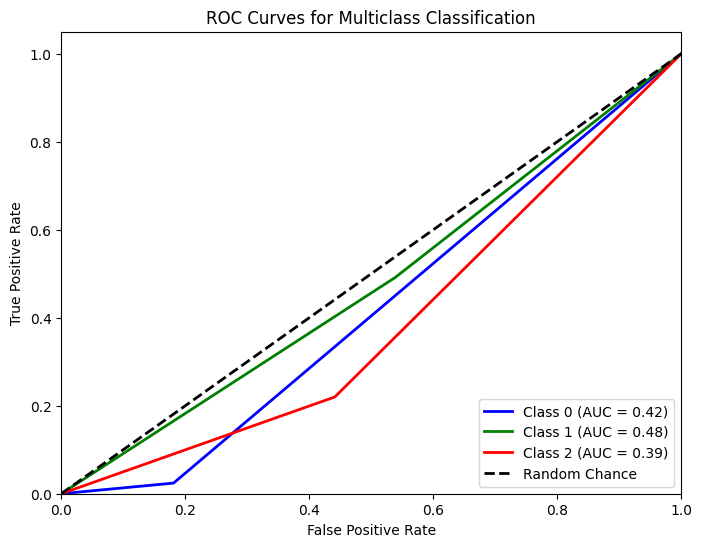

In [ ]:
print('=============================')
print('Métricas para o THRESHOLD = 3')
printClassificationResults(y_test_class3)


Métricas para o THRESHOLD = 5
Métricas por classe:
Precisão: [0.06944444 0.29360465 0.1888412 ]
Recall: [0.02145923 0.50248756 0.20465116]
F1-Score: [0.03278689 0.3706422  0.19642857]
AUC Médio: [0.43020077 0.48003842 0.38458365]

Média das métricas:
Acurácia: 0.23112480739599384
Precisão: 0.23112480739599384
Recall: 0.23112480739599384
F1-Score: 0.23112480739599384
AUC Médio: 0.42334360554699546



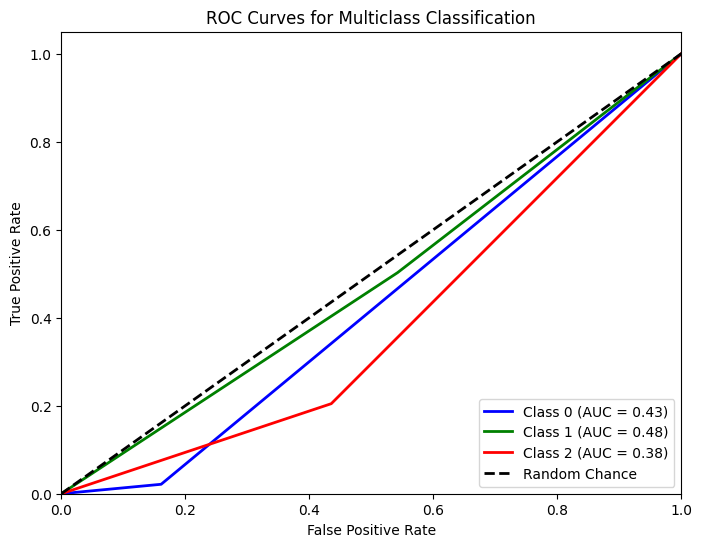

In [ ]:
print('=============================')
print('Métricas para o THRESHOLD = 5')
printClassificationResults(y_test_class5)


Métricas para o THRESHOLD = 7
Métricas por classe:
Precisão: [0.06944444 0.37790698 0.13733906]
Recall: [0.02380952 0.49056604 0.18390805]
F1-Score: [0.03546099 0.42692939 0.15724816]
AUC Médio: [0.43559497 0.46663719 0.38037508]

Média das métricas:
Acurácia: 0.2573189522342065
Precisão: 0.2573189522342065
Recall: 0.2573189522342065
F1-Score: 0.2573189522342065
AUC Médio: 0.44298921417565484



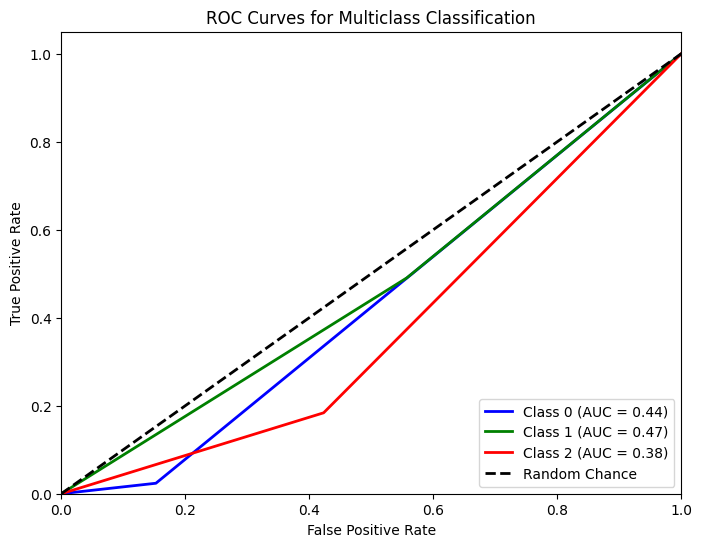

In [ ]:
print('=============================')
print('Métricas para o THRESHOLD = 7')
printClassificationResults(y_test_class7)